Code from https://github.com/a1k12/characterizing-pinns-failure-modes/blob/main/pbc_examples/main_pbc.py

It doesn't have an argument for curriculum training out of the box, but we can do a bad implementation ourselves by restarting training from models pretrained on smaller values of $\beta$.

Overall, these are nice scripts to familiarize ourselves with vanilla PINN training setups.

**Highlights from Paper**:

"We show that PINNs can only learn simple problems with very
small parameter values (e.g., small convection or reaction coefficients). We demonstrate that these
models fail to learn the relevant physical phenomena for non-trivial cases (e.g., relatively larger
coefficients). As we will see, while adding the physical constraint as a soft regularization may be
easier to deploy and optimize with existing unconstrained optimization methods, this approach does
come with trade-offs"


"For reasons that are only partially understood, L-BFGS methods tend to perform better for existing PINN
problems. While variants of stochastic gradient descent are much more popular in computer vision, natural
language processing, and recommendation systems, we found that they underperform in comparison to L-BFGS."


"One of the difficulties with PINNs arises from the soft regularization term that includes differential
operators. This term is quite different from norm-based regularization that is more common in ML,
and this can actually make the problem more ill-conditioned (or less regularized)."

In [17]:
!pip install --q torch_optimizer

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import argparse
from net_pbc import *
import numpy as np
import os
import random
import torch
from systems_pbc import *
import torch.backends.cudnn as cudnn
# from utils import *
# from visualize import *
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

In [21]:
import torch.optim as optim

In [22]:
import numpy as np
import random
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sample_random(X_all, N):
    """Given an array of (x,t) points, sample N points from this."""
    set_seed(0) # this can be fixed for all N_f

    idx = np.random.choice(X_all.shape[0], N, replace=False)
    X_sampled = X_all[idx, :]

    return X_sampled

def set_activation(activation):
    if activation == 'identity':
        return nn.Identity()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'relu':
        return  nn.ReLU()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        print("WARNING: unknown activation function!")
        return -1

In [23]:
"""
Visualize outputs.
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def exact_u(Exact, x, t, nu, beta, rho, layers, N_f, L, source, u0_str, system, path, savefigs=True):
    """Visualize exact solution."""
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15)

    line = np.linspace(x.min(), x.max(), 2)[:,None]

    ax.set_xlabel('t', fontweight='bold', size=30)
    ax.set_ylabel('x', fontweight='bold', size=30)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    ax.tick_params(labelsize=15)
    ax.set_title("Exact solution")
    if savefigs:
        plt.savefig(f"{path}/exactu_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_source{source}_{u0_str}.pdf")
    
    # plt.close()
    return None

def u_diff(Exact, U_pred, x, t, nu, beta, rho, seed, layers, N_f, L, source, lr, u0_str, system, path, relative_error = False, savefigs=True):
    """Visualize abs(u_pred - u_exact)."""

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    if relative_error:
        h = ax.imshow(np.abs(Exact.T - U_pred.T)/np.abs(Exact.T), interpolation='nearest', cmap='binary',
                    extent=[t.min(), t.max(), x.min(), x.max()],
                    origin='lower', aspect='auto')
    else:
        h = ax.imshow(np.abs(Exact.T - U_pred.T), interpolation='nearest', cmap='binary',
                    extent=[t.min(), t.max(), x.min(), x.max()],
                    origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15)

    line = np.linspace(x.min(), x.max(), 2)[:,None]

    ax.set_xlabel('t', fontweight='bold', size=30)
    ax.set_ylabel('x', fontweight='bold', size=30)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    ax.tick_params(labelsize=15)

    ax.set_title("Abs error")
    if savefigs:
        plt.savefig(f"{path}/udiff_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_seed{seed}_source{source}_{u0_str}_lr{lr}.pdf")
        

    return None

def u_predict(u_vals, U_pred, x, t, nu, beta, rho, seed, layers, N_f, L, source, lr, u0_str, system, path, savefigs=True):
    """Visualize u_predicted."""

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    # colorbar for prediction: set min/max to ground truth solution.
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto', vmin=u_vals.min(0), vmax=u_vals.max(0))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15)

    line = np.linspace(x.min(), x.max(), 2)[:,None]

    ax.set_xlabel('t', fontweight='bold', size=30)
    ax.set_ylabel('x', fontweight='bold', size=30)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    ax.set_title("Predicted u")

    ax.tick_params(labelsize=15)
    if savefigs:
        plt.savefig(f"{path}/upredicted_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_seed{seed}_source{source}_{u0_str}_lr{lr}.pdf")
        # plt.close()
    return None

In [33]:
################
# Arguments
################
parser = argparse.ArgumentParser(description='Characterizing/Rethinking PINNs')

parser.add_argument('--system', type=str, default='convection', help='System to study.')
parser.add_argument('--seed', type=int, default=0, help='Random initialization.')
parser.add_argument('--N_f', type=int, default=100, help='Number of collocation points to sample.')
parser.add_argument('--optimizer_name', type=str, default='LBFGS', help='Optimizer of choice.')
# parser.add_argument('--optimizer_name', type=str, default='Shampoo', help='Optimizer of choice.')
parser.add_argument('--lr', type=float, default=1.0, help='Learning rate.')
parser.add_argument('--L', type=float, default=1.0, help='Multiplier on loss f.')

parser.add_argument('--xgrid', type=int, default=256, help='Number of points in the xgrid.')
parser.add_argument('--nt', type=int, default=100, help='Number of points in the tgrid.')
parser.add_argument('--nu', type=float, default=1.0, help='nu value that scales the d^2u/dx^2 term. 0 if only doing advection.')
parser.add_argument('--rho', type=float, default=1.0, help='reaction coefficient for u*(1-u) term.')
parser.add_argument('--beta', type=float, default=15.0, help='beta value that scales the du/dx term. 0 if only doing diffusion.')
parser.add_argument('--u0_str', default='sin(x)', help='str argument for initial condition if no forcing term.')
parser.add_argument('--source', default=0, type=float, help="If there's a source term, define it here. For now, just constant force terms.")

parser.add_argument('--layers', type=str, default='50,50,50,50,1', help='Dimensions/layers of the NN, minus the first layer.')
parser.add_argument('--net', type=str, default='DNN', help='The net architecture that is to be used.')
parser.add_argument('--activation', default='tanh', help='Activation to use in the network.')
parser.add_argument('--loss_style', default='mean', help='Loss for the network (MSE, vs. summing).')

parser.add_argument('--visualize', default=True, help='Visualize the solution.')
parser.add_argument('--save_model', default=True, help='Save the model for analysis later.')

## Aniket - add one more arg for loading model!
parser.add_argument('--load_model', default=True, help='Load a model for curricular.')

args = parser.parse_args(args=())

In [34]:
vars(args)

{'system': 'convection',
 'seed': 0,
 'N_f': 100,
 'optimizer_name': 'LBFGS',
 'lr': 1.0,
 'L': 1.0,
 'xgrid': 256,
 'nt': 100,
 'nu': 1.0,
 'rho': 1.0,
 'beta': 15.0,
 'u0_str': 'sin(x)',
 'source': 0,
 'layers': '50,50,50,50,1',
 'net': 'DNN',
 'activation': 'tanh',
 'loss_style': 'mean',
 'visualize': True,
 'save_model': True,
 'load_model': True}

In [26]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nu = args.nu
beta = args.beta
rho = args.rho

if args.system == 'diffusion': # just diffusion
    beta = 0.0
    rho = 0.0
elif args.system == 'convection':
    nu = 0.0
    rho = 0.0
elif args.system == 'rd': # reaction-diffusion
    beta = 0.0
elif args.system == 'reaction':
    nu = 0.0
    beta = 0.0

print('nu', nu, 'beta', beta, 'rho', rho)

# parse the layers list here
orig_layers = args.layers
layers = [int(item) for item in args.layers.split(',')]

############################
# Process data
############################

x = np.linspace(0, 2*np.pi, args.xgrid, endpoint=False).reshape(-1, 1) # not inclusive
t = np.linspace(0, 1, args.nt).reshape(-1, 1)
X, T = np.meshgrid(x, t) # all the X grid points T times, all the T grid points X times
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) # all the x,t "test" data

# remove initial and boundaty data from X_star
t_noinitial = t[1:]
# remove boundary at x=0
x_noboundary = x[1:]
X_noboundary, T_noinitial = np.meshgrid(x_noboundary, t_noinitial)
X_star_noinitial_noboundary = np.hstack((X_noboundary.flatten()[:, None], T_noinitial.flatten()[:, None]))

# sample collocation points only from the interior (where the PDE is enforced)
X_f_train = sample_random(X_star_noinitial_noboundary, args.N_f)

if 'convection' in args.system or 'diffusion' in args.system:
    u_vals = convection_diffusion(args.u0_str, nu, beta, args.source, args.xgrid, args.nt)
    G = np.full(X_f_train.shape[0], float(args.source))
elif 'rd' in args.system:
    u_vals = reaction_diffusion_discrete_solution(args.u0_str, nu, rho, args.xgrid, args.nt)
    G = np.full(X_f_train.shape[0], float(args.source))
elif 'reaction' in args.system:
    u_vals = reaction_solution(args.u0_str, rho, args.xgrid, args.nt)
    G = np.full(X_f_train.shape[0], float(args.source))
else:
    print("WARNING: System is not specified.")

u_star = u_vals.reshape(-1, 1) # Exact solution reshaped into (n, 1)
Exact = u_star.reshape(len(t), len(x)) # Exact on the (x,t) grid

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) # initial condition, from x = [-end, +end] and t=0
uu1 = Exact[0:1,:].T # u(x, t) at t=0
bc_lb = np.hstack((X[:,0:1], T[:,0:1])) # boundary condition at x = 0, and t = [0, 1]
uu2 = Exact[:,0:1] # u(-end, t)

# generate the other BC, now at x=2pi
t = np.linspace(0, 1, args.nt).reshape(-1, 1)
x_bc_ub = np.array([2*np.pi]*t.shape[0]).reshape(-1, 1)
bc_ub = np.hstack((x_bc_ub, t))

u_train = uu1 # just the initial condition
X_u_train = xx1 # (x,t) for initial condition

layers.insert(0, X_u_train.shape[-1])

nu 0.0 beta 15.0 rho 0.0


In [27]:
layers

[2, 50, 50, 50, 50, 1]

In [28]:
############################
# Train the model
############################

set_seed(args.seed) # for weight initialization

if args.load_model:
    model = PhysicsInformedNN_pbc(args.system, X_u_train, u_train, X_f_train, bc_lb, bc_ub, layers, G, nu, , rho,
                            args.optimizer_name, args.lr, args.net, args.L, args.activation, args.loss_style)

    torch.load("pretrained_convection_u0sin(x)_nu0.0_beta15.0_rho0.0_Nf100_50,50,50,50,1_L1.0_source0_seed0.pt")

model = PhysicsInformedNN_pbc(args.system, X_u_train, u_train, X_f_train, bc_lb, bc_ub, layers, G, nu, beta, rho,
                            args.optimizer_name, args.lr, args.net, args.L, args.activation, args.loss_style)
model.train()


u_pred = model.predict(X_star)

error_u_relative = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
error_u_abs = np.mean(np.abs(u_star - u_pred))
error_u_linf = np.linalg.norm(u_star - u_pred, np.inf)/np.linalg.norm(u_star, np.inf)

epoch 0, gradient: 1.80618e+00, loss: 5.17517e-01, loss_u: 5.06934e-01, loss_b: 7.62809e-04, loss_f: 9.82022e-03
epoch 100, gradient: 1.06342e+00, loss: 3.44031e-01, loss_u: 2.58498e-01, loss_b: 5.58148e-02, loss_f: 2.97186e-02
epoch 200, gradient: 5.05384e+00, loss: 3.02552e-01, loss_u: 2.05085e-01, loss_b: 4.47319e-02, loss_f: 5.27351e-02
epoch 300, gradient: 6.54410e-01, loss: 2.57825e-01, loss_u: 1.64096e-01, loss_b: 3.87531e-02, loss_f: 5.49755e-02
epoch 400, gradient: 1.58439e+00, loss: 1.50523e-01, loss_u: 6.93620e-02, loss_b: 8.57233e-03, loss_f: 7.25885e-02
epoch 500, gradient: 8.84835e-01, loss: 5.26934e-02, loss_u: 2.06572e-02, loss_b: 1.29498e-02, loss_f: 1.90864e-02
epoch 600, gradient: 5.49193e-01, loss: 2.27577e-02, loss_u: 6.32610e-03, loss_b: 7.81791e-03, loss_f: 8.61373e-03
epoch 700, gradient: 1.50475e-01, loss: 7.19246e-03, loss_u: 4.35865e-03, loss_b: 7.20353e-04, loss_f: 2.11345e-03
epoch 800, gradient: 1.23207e-01, loss: 5.25544e-03, loss_u: 3.44611e-03, loss_b: 

In [29]:
u_pred = model.predict(X_star)

error_u_relative = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
error_u_abs = np.mean(np.abs(u_star - u_pred))
error_u_linf = np.linalg.norm(u_star - u_pred, np.inf)/np.linalg.norm(u_star, np.inf)

print('Error u rel: %e' % (error_u_relative))
print('Error u abs: %e' % (error_u_abs))
print('Error u linf: %e' % (error_u_linf))

Error u rel: 9.714794e-01
Error u abs: 5.929376e-01
Error u linf: 1.170494e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


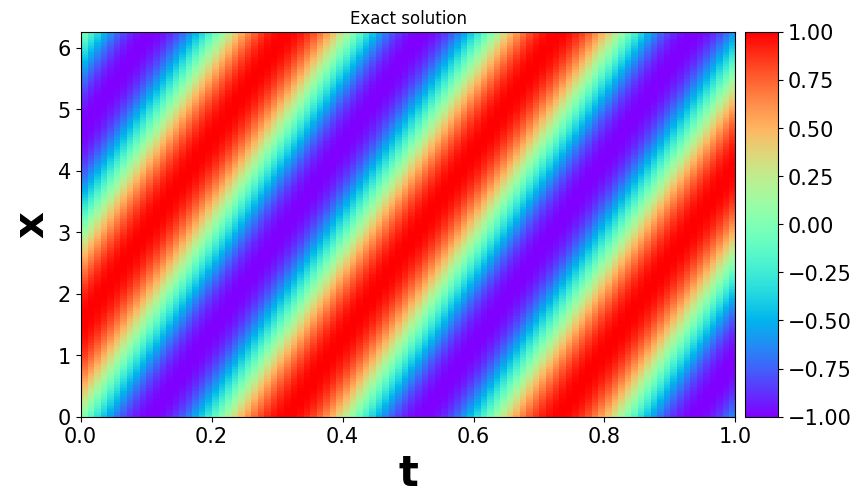

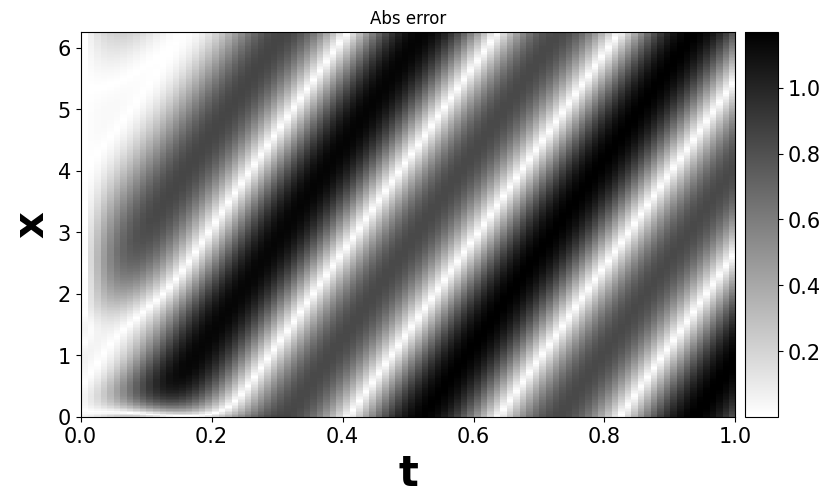

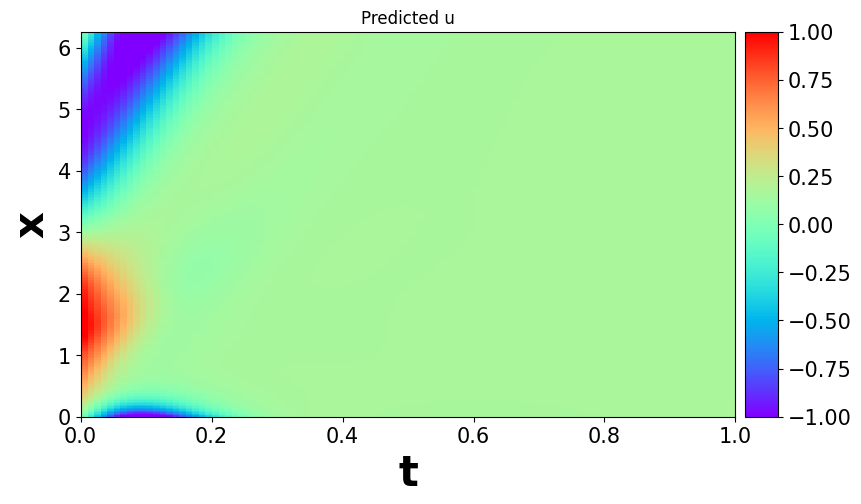

In [30]:
if args.visualize:
    path = f"heatmap_results/{args.system}"
    if not os.path.exists(path):
        os.makedirs(path)
    u_pred = u_pred.reshape(len(t), len(x))
    exact_u(Exact, x, t, nu, beta, rho, orig_layers, args.N_f, args.L, args.source, args.u0_str, args.system, path=path)
    u_diff(Exact, u_pred, x, t, nu, beta, rho, args.seed, orig_layers, args.N_f, args.L, args.source, args.lr, args.u0_str, args.system, path=path)
    u_predict(u_vals, u_pred, x, t, nu, beta, rho, args.seed, orig_layers, args.N_f, args.L, args.source, args.lr, args.u0_str, args.system, path=path)

In [31]:
if args.save_model: # whether or not to save the model
    path = "saved_models"
    if not os.path.exists(path):
        os.makedirs(path)
    if 'pretrained' not in args.net: # only save new models
        torch.save(model, f"saved_models/pretrained_{args.system}_u0{args.u0_str}_nu{nu}_beta{beta}_rho{rho}_Nf{args.N_f}_{args.layers}_L{args.L}_source{args.source}_seed{args.seed}.pt")

In [16]:
# print(f"saved_models/pretrained_{args.system}_u0{a`rgs.u0_str}_nu{nu}_beta{beta}_rho{rho}_Nf{args.N_f}_{args.layers}_L{args.L}_source{args.source}_seed{args.seed}.pt"

In [ ]:
# pretrained_convection_u0sin(x)_nu0.0_beta15.0_rho0.0_Nf100_50,50,50,50,1_L1.0_source0_seed0.pt